In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import mlflow
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from time import time

%cd ..
import src.mytools as mt
%cd notebooks

/home/chakir/Bureau/PROJETS/Projet6
/home/chakir/Bureau/PROJETS/Projet6/notebooks


In [3]:
# Chemin vers les dossiers 'train', 'validation' et 'test'
train_dir = '../data/train'
val_dir = '../data/validation'
test_dir = '../data/test'

class_names = os.listdir(val_dir)

In [4]:
# Fixation des sources des générateurs aléatoires pour assurer la reproductibilité des résultats.
seed_value = 42
set_random_seed(seed_value)

In [12]:
mlflow.set_tracking_uri("http://ec2-52-209-5-80.eu-west-1.compute.amazonaws.com:5000")
mlflow.set_experiment('projet6_transfer-learning')

2024/07/17 18:57:53 INFO mlflow.tracking.fluent: Experiment with name 'projet6_transfer-learning' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow-cfikri/937544924322822054', creation_time=1721235473336, experiment_id='937544924322822054', last_update_time=1721235473336, lifecycle_stage='active', name='projet6_transfer-learning', tags={}>

### GÉNÉRATEUR DE DONNÉES

In [14]:
# Définition des générateurs de données

t_generator = ImageDataGenerator(rescale=1./255,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 zoom_range=0.4,
                                 horizontal_flip=True,
                                 fill_mode='nearest'
                                )

generator = ImageDataGenerator(rescale=1./255)

train_generator = t_generator.flow_from_directory(train_dir,
                                                  target_size=(256, 256),
                                                  class_mode='categorical',
                                                  seed=seed_value
                                                 )

val_generator = generator.flow_from_directory(val_dir,
                                              target_size=(256, 256),
                                              class_mode='categorical',
                                              shuffle=False,
                                              seed=seed_value
                                             )

Found 288 images belonging to 3 classes.
Found 72 images belonging to 3 classes.


### VGG16

In [17]:
# Chargement du modèle VGG16 pré-entraîné sans les couches supérieures
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Fixation des couches de base du modèle VGG16 pour ne pas les réentraîner
for layer in base_model.layers:
    layer.trainable = False

In [19]:
# Ajouter vos propres couches de classification
model = Sequential([base_model,
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(3, activation='softmax')
                   ])

In [21]:
history, temps_execution = mt.compile_and_train(model, train_generator, val_generator, optimizer=Nadam, epochs=100)
print(f"durée d'exécution : {temps_execution} min")

Epoch 1/100


/home/chakir/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-07-17 18:58:44.248052: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.
2024-07-17 18:58:44.511971: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.


1/9 ━━━━━━━━━━━━━━━━━━━━ 1:22 10s/step - accuracy: 0.3750 - auc: 0.5100 - loss: 1.4281 - precision: 0.3750 - recall: 0.3750

2024-07-17 18:58:49.663623: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.
2024-07-17 18:58:49.924504: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.


2/9 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.3828 - auc: 0.5268 - loss: 8.5125 - precision: 0.3828 - recall: 0.3828  

2024-07-17 18:58:55.204889: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.


9/9 ━━━━━━━━━━━━━━━━━━━━ 73s 8s/step - accuracy: 0.3403 - auc: 0.5091 - loss: 11.2785 - precision: 0.3403 - recall: 0.3403 - val_accuracy: 0.4306 - val_auc: 0.6954 - val_loss: 1.1007 - val_precision: 0.4576 - val_recall: 0.3750 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 74s 8s/step - accuracy: 0.3809 - auc: 0.5785 - loss: 2.0336 - precision: 0.3858 - recall: 0.3711 - val_accuracy: 0.6944 - val_auc: 0.8978 - val_loss: 0.6276 - val_precision: 0.7313 - val_recall: 0.6806 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 76s 8s/step - accuracy: 0.6524 - auc: 0.8189 - loss: 0.8277 - precision: 0.6915 - recall: 0.6059 - val_accuracy: 0.7500 - val_auc: 0.8944 - val_loss: 0.6166 - val_precision: 0.7761 - val_recall: 0.7222 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 76s 8s/step - accuracy: 0.7194 - auc: 0.8880 - loss: 0.6416 - precision: 0.7697 - recall: 0.6763 - val_accuracy: 0.7500 - val_auc: 0.9158 - val_loss: 0.5577 - val_precision: 0.7612 - va

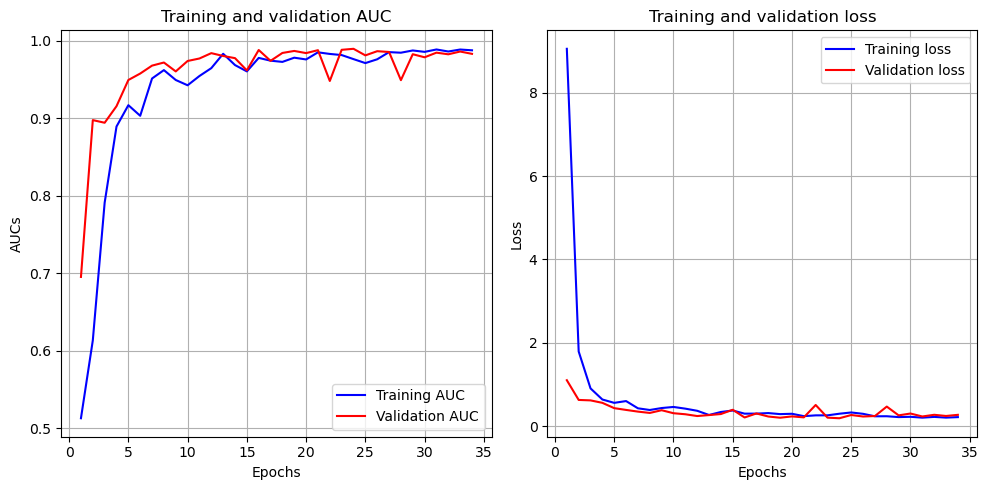

In [23]:
mt.graphique_auc_perte(history, 'VGG16')

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step


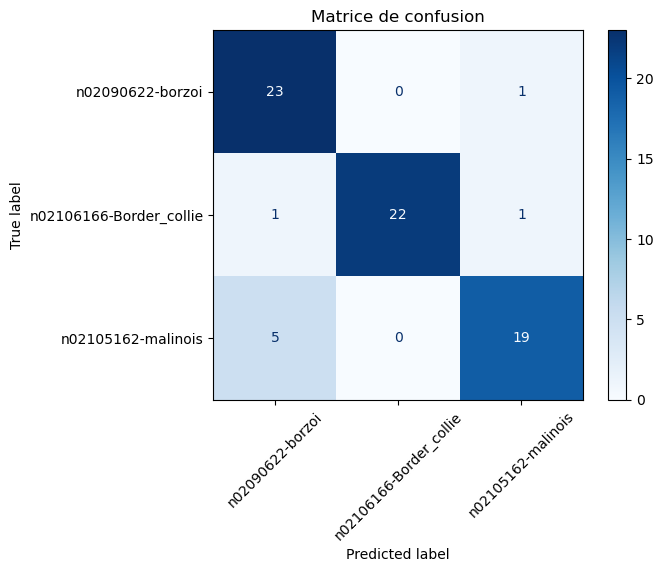

In [25]:
mt.matrice_confusion(model, 'VGG16', val_generator, class_names)

In [27]:
params = {'algorithme' : 'VGG16',  
          'optimizer' : 'Nadam', 
          'fonction_perte' : 'categorical_crossentropy',
          'learning_rate' : 0.001,
          'nbr_epoques' : 100}

metrics = {'accuracy' : max(history.history['val_accuracy']),
           'precision' : max(history.history['val_precision']),
           'recall' : max(history.history['val_recall']),
           'auc-roc' : max(history.history['val_auc'])}

tags = {'Dataset' : 'Stanford Dogs Dataset', 'algorithme' : 'VGG16'}

artifacts = {"Evolution du AUC-ROC et de l'entropie croisée au cours des époques" : '../outputs/courbes_performances_VGG16.png',
             'Matrice de confusion' : '../outputs/matrice_confusion_VGG16.png'}

mt.log_mlflow_run('VGG16_transfer_learning', 
                  params, 
                  metrics, 
                  tags=tags, 
                  artifacts=artifacts,
                  model=model,
                  model_type='tensorflow',
                  model_name='VGG16')

2024/07/17 19:57:16 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
/home/chakir/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### INCEPTIONV3

In [30]:
# Charger le modèle InceptionV3 pré-entraîné sans les couches supérieures
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Geler les couches de base du modèle InceptionV3 pour ne pas les entraîner
for layer in base_model.layers:
    layer.trainable = False

In [32]:
# Ajouter vos propres couches de classification
model = Sequential([base_model,
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(3, activation='softmax')
                   ])

In [34]:
history, temps_execution = mt.compile_and_train(model, train_generator, val_generator, optimizer=Nadam, epochs=100)
print(f"durée d'exécution : {temps_execution} min")

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.5230 - auc: 0.6649 - loss: 43.9125 - precision: 0.5256 - recall: 0.5139 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 8.4686e-05 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9707 - auc: 0.9817 - loss: 0.6477 - precision: 0.9707 - recall: 0.9707 - val_accuracy: 0.9861 - val_auc: 0.9896 - val_loss: 0.5534 - val_precision: 0.9861 - val_recall: 0.9861 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9681 - auc: 0.9849 - loss: 0.5758 - precision: 0.9681 - recall: 0.9681 - val_accuracy: 0.9861 - val_auc: 0.9896 - val_loss: 0.1913 - val_precision: 0.9861 - val_recall: 0.9861 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9688 - auc: 0.9858 - loss: 0.3705 - precision: 0.9688 - recall: 0.9688 - val_accuracy: 0.9861 - val_auc: 0.9895 - val_loss: 0.6537 - val_precis

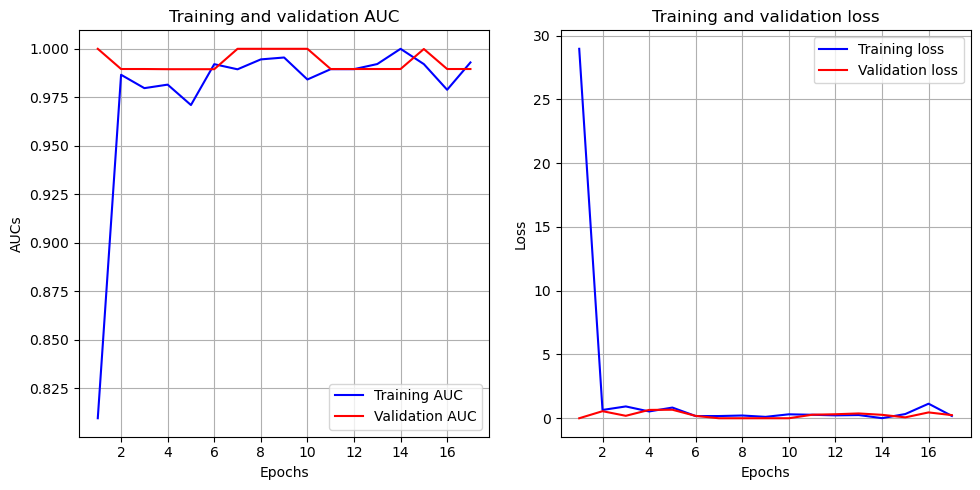

In [36]:
mt.graphique_auc_perte(history, 'InceptionV3')

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


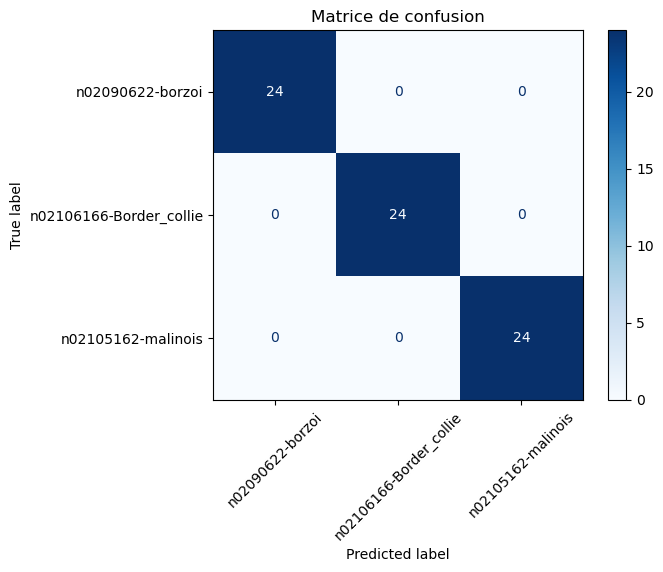

In [38]:
mt.matrice_confusion(model, 'InceptionV3', val_generator, class_names)

In [40]:
params = {'algorithme' : 'InceptionV3',  
          'optimizer' : 'Nadam', 
          'fonction_perte' : 'categorical_crossentropy',
          'learning_rate' : 0.001,
          'nbr_epoques' : 100}

metrics = {'accuracy' : max(history.history['val_accuracy']),
           'precision' : max(history.history['val_precision']),
           'recall' : max(history.history['val_recall']),
           'auc-roc' : max(history.history['val_auc'])}

tags = {'Dataset' : 'Stanford Dogs Dataset', 'algorithme' : 'InceptionV3'}

artifacts = {"Evolution du AUC-ROC et de l'entropie croisée au cours des époques" : '../outputs/courbes_performances_InceptionV3.png',
             'Matrice de confusion' : '../outputs/matrice_confusion_InceptionV3.png'}

mt.log_mlflow_run('InceptionV3_transfer_learning', 
                  params, 
                  metrics, 
                  tags=tags, 
                  artifacts=artifacts,
                  model=model,
                  model_type='tensorflow',
                  model_name='InceptionV3')

2024/07/17 20:37:21 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
